In [ ]:
# default_exp resnet34_preclassify

# Resnet34 : pretrain for classification

> In this method, we pretrain the model for 10 epochs with the usual classification task to get good
stable weights to start with. We then go on to train the model for our class similarity task. This seems to work much better than the previous approach. Regardless, there's still a long way to go.

In [ ]:
#hide
%config autocompleter.use_jedi=False
from nbdev.showdoc import *
from fastai.vision import *
import random

In [ ]:
from fastai.callbacks import *
from fastai import *
from fastai.callbacks.tensorboard import *

In [ ]:
PATH = untar_data(URLs.IMAGENETTE_320)
PATH.ls()

[PosixPath('/home/ubuntu/.fastai/data/imagenette-320/val'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-320/train'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-320/models')]

# Usual Model

In [ ]:
data = ImageDataBunch.from_folder(PATH, train='train', valid='val',
                                 ds_tfms=get_transforms(max_rotate=0, max_warp=0), size=224)

# data.show_batch()

len(data.train_ds)

12894

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy], pretrained=False).mixup()
gc.collect()

7

In [ ]:
tboard_path = Path.cwd()/'logs'/'imagenette'
learn.callback_fns.append(partial(LearnerTensorboardWriter, 
                                  base_dir=tboard_path, name='resnet34-pre-classify-1'))

In [ ]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,2.756369,2.245523,0.310000,00:32
1,2.228413,2.042853,0.330000,00:31
2,1.907944,1.912533,0.406000,00:31
3,1.670565,1.336960,0.518000,00:31
4,1.572767,1.132488,0.636000,00:31
5,1.501027,1.086984,0.702000,00:30
6,1.318683,0.733273,0.762000,00:30
7,1.234052,0.633128,0.812000,00:30
8,1.147737,0.507963,0.854000,00:31
9,1.097067,0.502568,0.852000,00:31


profiler execution failed


In [ ]:
learn2 = learn

In [ ]:
learn2.save('resnet34-preclassify-1-stage-1')

In [ ]:
def get_model(pretrained=True, learn=learn2):
    return learn.model

# Continuing

In [ ]:
TRAIN = PATH/'train'

In [ ]:
TRAIN.ls()

[PosixPath('/home/ubuntu/.fastai/data/imagenette-320/train/n03888257'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-320/train/n03000684'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-320/train/n03028079'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-320/train/n02102040'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-320/train/n03417042'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-320/train/n03394916'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-320/train/n03445777'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-320/train/n03425413'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-320/train/n02979186'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-320/train/n01440764')]

# Make CSV

In [ ]:
def get_label_from_names(names:Path):
    labels = []
    if is_listy(names):
        for name in names: 
            labels.append(Path(name).parent.name)
        return labels
    else: 
        return Path(names).parent.name
    
names = get_files(TRAIN, recurse=True, extensions='.JPEG')
get_label_from_names(names[:10])

['n03888257',
 'n03888257',
 'n03888257',
 'n03888257',
 'n03888257',
 'n03888257',
 'n03888257',
 'n03888257',
 'n03888257',
 'n03888257']

In [ ]:
def make_df(names:list):
    names2 = names.copy()
    random.shuffle(names2)
    df = pd.DataFrame(data=[names, names2]).T
    labels1 = np.array(get_label_from_names(list(df.iloc[:,0])))
    labels2 = np.array(get_label_from_names(list(df.iloc[:,1])))
    labels = (labels1 == labels2).astype(np.int32)
    df['label'] = labels
    df.columns = ['image1', 'image2', 'label']
    return df

df = make_df(get_files(TRAIN, recurse=True, extensions='.JPEG'))
df.head()

,image1,image2,label
0,/home/ubuntu/.fastai/data/imagenette-320/train...,/home/ubuntu/.fastai/data/imagenette-320/train...,0
1,/home/ubuntu/.fastai/data/imagenette-320/train...,/home/ubuntu/.fastai/data/imagenette-320/train...,0
2,/home/ubuntu/.fastai/data/imagenette-320/train...,/home/ubuntu/.fastai/data/imagenette-320/train...,0
3,/home/ubuntu/.fastai/data/imagenette-320/train...,/home/ubuntu/.fastai/data/imagenette-320/train...,0
4,/home/ubuntu/.fastai/data/imagenette-320/train...,/home/ubuntu/.fastai/data/imagenette-320/train...,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcad44cda50>]], dtype=object)

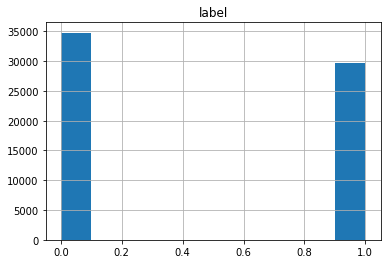

In [ ]:
def make_csv_from_path(TRAIN=TRAIN, mult=5):
    TRAIN = Path(TRAIN)
    names60 = []
    dfs = []
    for d in TRAIN.ls():
        names = d.ls() * mult
        random.shuffle(names)
        names40 = names[:int(len(names)*0.4)]
        names60.extend(names[int(len(names)*0.4):])
        dfs.append(make_df(names40))
        
    df60 = make_df(names60)
    for df in dfs:
        df60 = df60.append(df)

    return df60

df = make_csv_from_path(TRAIN)
df.hist()

# FastAI Databunch

In [ ]:
df.head()

,image1,image2,label
0,/home/ubuntu/.fastai/data/imagenette-320/train...,/home/ubuntu/.fastai/data/imagenette-320/train...,0
1,/home/ubuntu/.fastai/data/imagenette-320/train...,/home/ubuntu/.fastai/data/imagenette-320/train...,0
2,/home/ubuntu/.fastai/data/imagenette-320/train...,/home/ubuntu/.fastai/data/imagenette-320/train...,0
3,/home/ubuntu/.fastai/data/imagenette-320/train...,/home/ubuntu/.fastai/data/imagenette-320/train...,0
4,/home/ubuntu/.fastai/data/imagenette-320/train...,/home/ubuntu/.fastai/data/imagenette-320/train...,0


In [ ]:
learn = None
data = None
gc.collect()

20

In [ ]:
size = 256
class DoubleImageList(ImageList):
    def open(self, fn):
        im1 = open_image(fn[0]).resize(size)
        im2 = open_image(fn[1]).resize(size)
        black_space = torch.zeros(3, size, 20)
        return Image(torch.cat([im1.data, black_space, im2.data], dim = 2))

In [ ]:
data = (DoubleImageList.from_df(df, path='/', cols=['image1', 'image2'])
        .split_by_rand_pct(0.2)
        .label_from_df(cols=['label'])
        .transform(get_transforms(max_rotate=0, max_warp=0))
        .databunch(bs=128)
        .normalize(imagenet_stats))

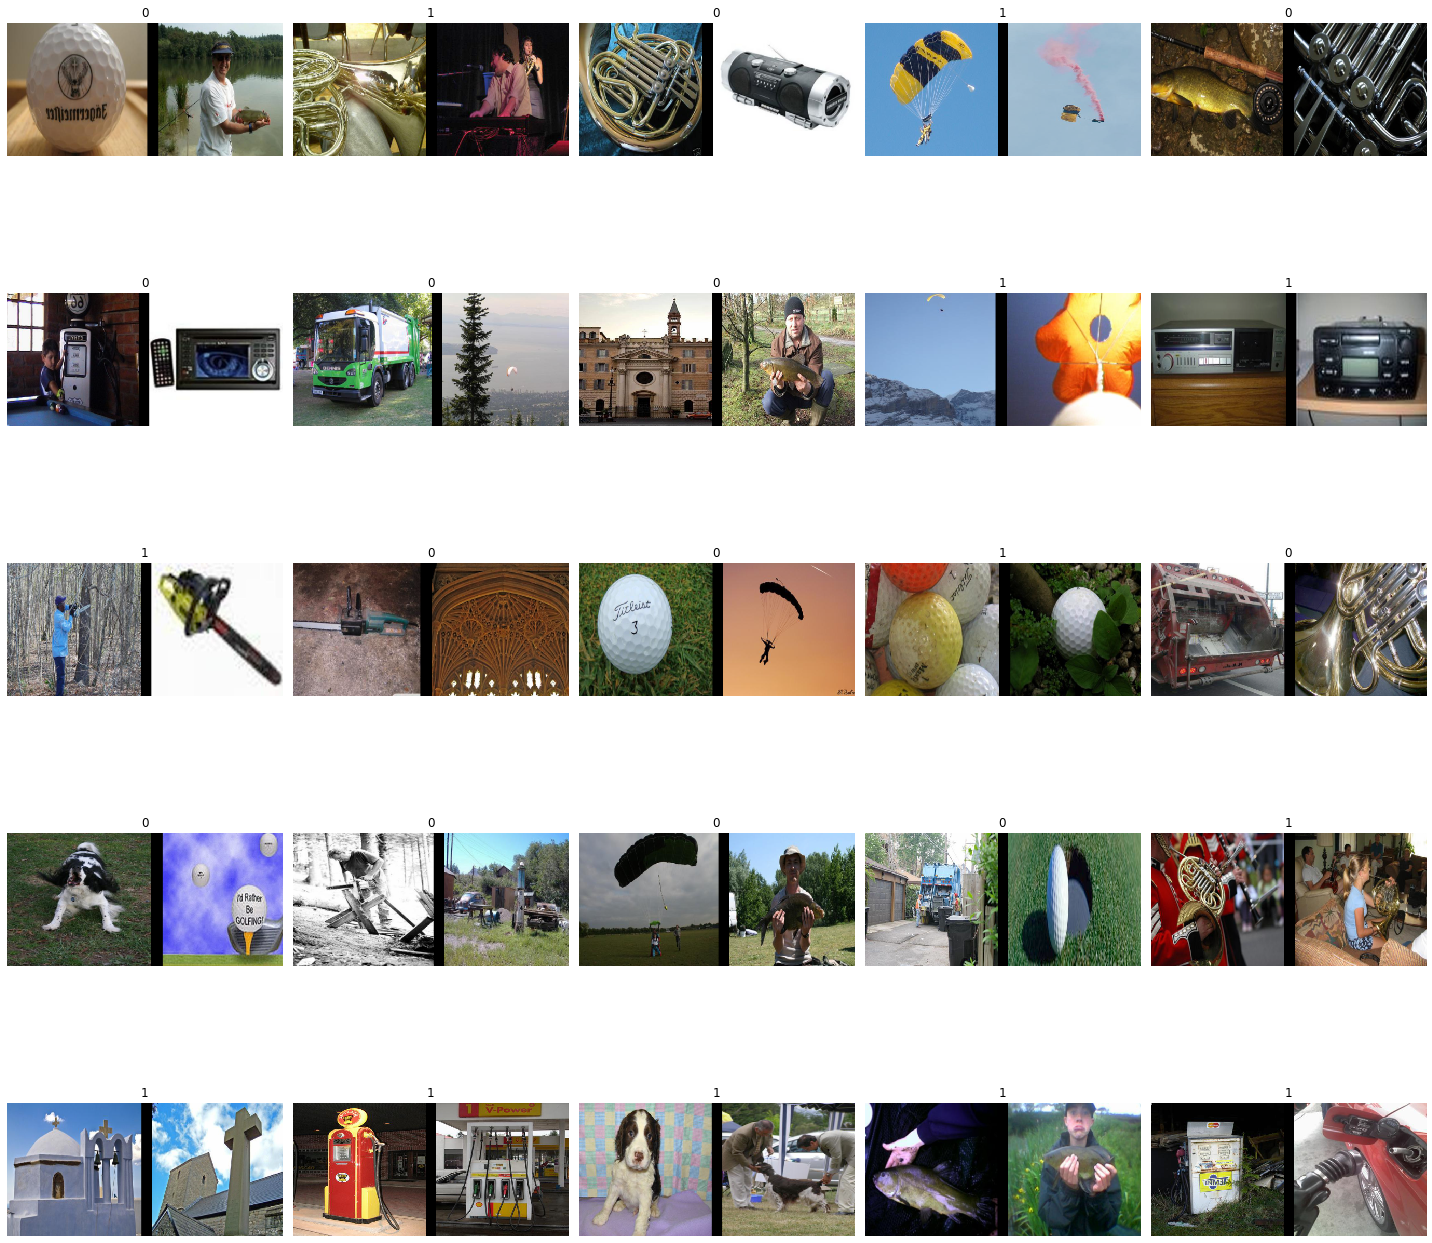

In [ ]:
data.show_batch()

# Model

In [ ]:
# m = models.xresnet50

# mom, alpha, eps = 0.9, 0.99, 1e-6
# opt_func = partial(optim.Adam, betas=(mom,alpha), eps=eps)

# learn = (Learner(data, m(c_out=10), wd=1e-2, opt_func=opt_func,
#         metrics=[accuracy],
#         bn_wd=False, true_wd=True,
#         loss_func = LabelSmoothingCrossEntropy())
#         )

In [ ]:
learn = cnn_learner(data, get_model, metrics=[accuracy], pretrained=False)
gc.collect()

52776

In [ ]:
tboard_path = Path.cwd()/'logs'/'imagenette'
learn.callback_fns.append(partial(LearnerTensorboardWriter, 
                                  base_dir=tboard_path, name='resnet34-pre-classify-1-stage-2'))

In [ ]:
learn2 = None
gc.collect()

40

In [ ]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.623416,0.486171,0.763301,05:02
1,0.540685,0.851803,0.698464,04:59
2,0.470886,0.811686,0.657903,04:58
3,0.401955,0.442581,0.787498,04:57
4,0.345322,0.459940,0.799054,04:59
5,0.276416,0.285856,0.875524,04:59
6,0.215512,0.226548,0.908174,04:58
7,0.165785,0.170776,0.933613,04:57
8,0.124874,0.139859,0.946332,04:59
9,0.105880,0.133501,0.950132,05:00


profiler execution failed


# Testing

1. Take N images from each class as query images
2. For each image in validation set:
    1. Create sample with each support image
    2. Stack in one batch
    3. Get predictions
    4. Get mean probabilities
    5. ARGMAX

In [ ]:
TRAIN = TRAIN
VAL = PATH/'val'

In [ ]:
num_images = 7
classes = 10
query_images = OrderedDict()
random.seed(22)
for d in TRAIN.ls():
    cls = d.name
    images = d.ls()
    random.shuffle(images)
    images = images[:num_images]
    query_images[cls] = images

In [ ]:
samples = get_files(VAL, extensions='.JPEG', recurse=True)

In [ ]:
def create_sample_from_paths(path1, path2):
    im1 = open_image(path1).resize(320)
    im2 = open_image(path2).resize(320)
    black_space = torch.zeros(3, 320, 20)
    image = torch.cat([im1.data, black_space, im2.data], dim = 2)
    image = learn.data.norm((image, torch.zeros(1)))[0].unsqueeze(0).cuda()
    return image

In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
total, accurate, accuracy = 0.0, 0.0, 0.0
predictions = []
pbar = tqdm(samples)
learn.model.eval()
for sample in pbar:
    label = get_label_from_names(sample)
    positive, negative = [], []
    for key, value in query_images.items():
        if key == label:
            for val in value:
                positive.append(create_sample_from_paths(sample, val))
        else:
            for val in value:
                negative.append(create_sample_from_paths(sample, val))
    positive.extend(negative)
    stack = torch.cat(positive, dim=0)
    predictions.append(learn.model(stack)[:,1].reshape(classes, num_images).detach().cpu())
    preds = predictions[-1].mean(1).argmax().item()
    if preds == 0:
        accurate += 1
    total += 1
    accuracy = accurate / total
    pbar.set_description(f"Accuracy : {accuracy}")
print(accurate/total)


0.89


In [ ]:
learn.path = Path.cwd()/'models'

In [ ]:
learn.save('resnet34-preclassify-1-stage-2')